<a href="https://colab.research.google.com/github/jaykorrapati/mdst_win2021/blob/master/SIADS591_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Yahoo finance install and example below:

In [1]:
!pip install yfinance
import yfinance as yf

#example:

gme = yf.download("GME", start="2021-01-01", end="2021-09-02")

     |████████████████████████████████| 6.3 MB 3.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=ed911a9b2e7f5dc4243dfb67cade816893bf67af7dcee105bfa558fa0b610224
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
[*********************100%***********************]  1 of 1 completed


**Jay's workspace**

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('words')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
#Code to load submission_redditt.csv from https://www.kaggle.com/leukipp/reddit-finance-data-getting-started
import os
import glob as gb
import numpy as np
import pandas as pd
import altair as alt
import re
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
cmap = sns.cm.mako_r

%matplotlib inline
#import nltk related modules
import re
from nltk import word_tokenize, corpus
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer

english_words = set(corpus.words.words())

from IPython.core.display import HTML

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
#copied the wallstreetbets file into a subfolder on my google drive and now loading the file
files = []
for folder, _, dataset in os.walk('/content/drive/MyDrive'):
    files = files + [os.path.join(folder, x) for x in dataset if x.endswith('reddit.csv')]
dfs = {os.path.basename(os.path.dirname(x)): pd.read_csv(x) for x in files}


In [ ]:
#load the file into a pandas dataframe
list(dfs.keys())
df = dfs['MyDrive']

df.shape

(680109, 24)

In [ ]:
#listing fields of interest 
df.title.unique
df.author.unique
df.link_flair_text.unique
df.selftext.unique
#df = df[['title','author','link_flair_text','selftext','created']]

df.shape

(65280, 24)

In [ ]:
#Cleanup text
#ignore the records which are removed/delete by reditt admin (removed flag != 1)
df = df[df['removed'] == 0]

#converting the created field to a datetime column
df['created'] = pd.to_datetime(df['created'])

#drop the records with null values in the dataframe columns 'created', 'title, and 'selftext'
df_title = df[['created','title']].dropna()
df_selftext = df[['created','selftext']].dropna()

#user defined function below to clean up the text data in the 2 dataframe columns 'title' and 'selftext'

def clean_text_date(text):
    text = text.lower()

    # Replacing Handlers with Empty String
    text = re.sub('@[^\s]+','',text)

    # Replacing URLs with Empty String
    text = re.sub(r"http\S+", "",text)

    # Remove all the special characters
    text = ' '.join(re.findall(r'\w+', text))

    # Replacing Single Characters with Empty String
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Removing Extra Spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    return text

    
# Text Preprocessing
df_title['title'] = df_title['title'].apply(lambda x : clean_text_date(x))
df_selftext['selftext'] = df_selftext['selftext'].apply(lambda x : clean_text_date(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#the list of stocks we are interested in for this analysis
stock_list = ["gme","gamestop","amc"]
df_title = df_title[df_title['title'].str.contains('|'.join(stock_list))]
df_selftext = df_selftext[df_selftext['selftext'].str.contains('|'.join(stock_list))]

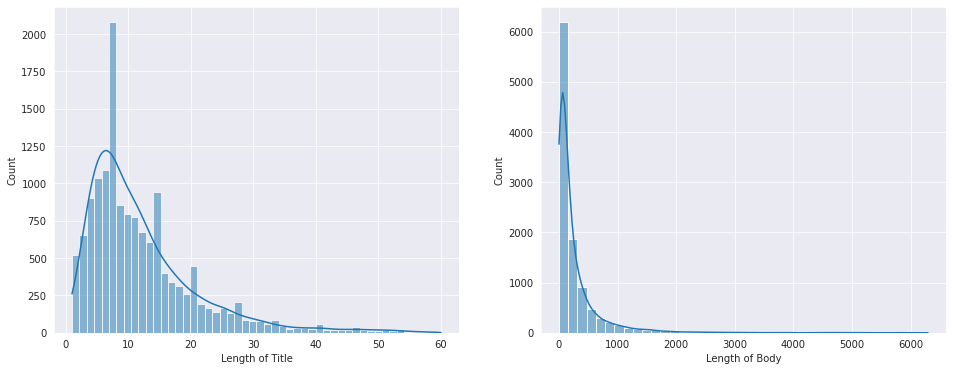

In [ ]:
#Plotting a Histograms to see the Length(No. of words) Distribution of words in the two columns 'title' and 'selftext'
title_length = [len(word_tokenize(text)) for text in df_title['title']]
body_length = [len(word_tokenize(text)) for text in df_selftext['selftext']]

fig, (axis1, axis2) = plt.subplots(1,2, figsize=(16,6))

sns.histplot(title_length, bins=50, kde=True, ax=axis1)
sns.histplot(body_length, bins=40, kde=True, ax=axis2)

axis1.set_xlabel("Length of Title")
axis2.set_xlabel("Length of Body")

plt.show()

In [ ]:
#Sentiment Analysis Using SentimentIntensityAnalyzer from nltk.sentiment
def get_sentiment(sia, text):
    if sia.polarity_scores(text)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(text)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral"

sia = SentimentIntensityAnalyzer()    
#convert the datetime column 'created' into a date column .This can be used subsequently to plot the numbers by day
df_title['created'] = pd.to_datetime(df['created']).dt.date  
df_title['Sentiment'] = df_title['title'].apply(lambda x : get_sentiment(sia, x))
df_selftext['Sentiment'] = df_selftext['selftext'].apply(lambda x : get_sentiment(sia, x))

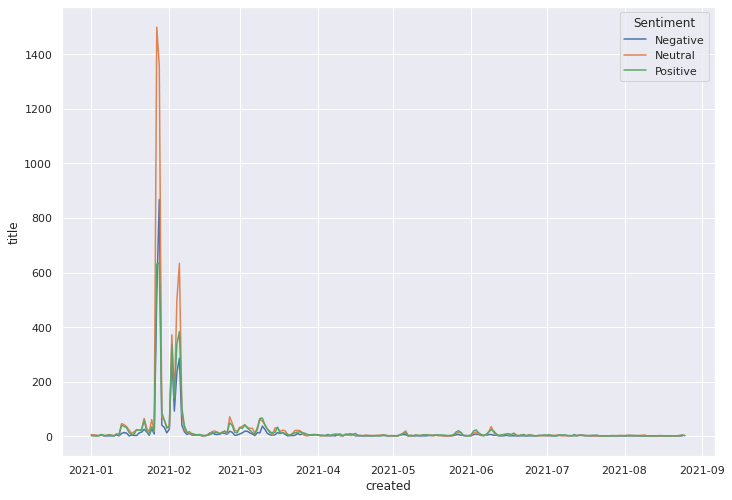

In [ ]:
#create a new data frame with the count of different sentiments by each day
df_title_sns = df_title
df_title_sns = df_title_sns.groupby(['created','Sentiment']).agg('count').reset_index()
#create a new data frame to plot the ratio of sentiments 
df_title_ratio = df_title_sns.pivot(index='created', columns='Sentiment').reset_index()
#flatten the pivot table
df_title_ratio  = pd.DataFrame(df_title_ratio.to_records() )
#manually label the columns
df_title_ratio.columns = ['index','created','Negative','Neutral','Positive']
#drop a redundant column
df_title_ratio.drop(['index'], axis=1)
#fill in the NA values
df_title_ratio.fillna(0)

#set the seaborn plot size 
sns.set(rc={'figure.figsize':(11.7,8.27)})
#create a line plot
sns.lineplot(data=df_title_sns, x="created",y='title',  hue='Sentiment')

In [ ]:
#create a new data frame with the count of different sentiments by each day
##df_title.groupby('created')
df_title_temp = df_title[['created','Sentiment']]
#df_title_temp.groupby('created',as_index = False).sum().pivot('created', 'Sentiment').fillna(0)
df_title_ratio = df_title_sns.pivot(index='created', columns='Sentiment').reset_index()
df_title_ratio  = pd.DataFrame(df_title_ratio.to_records() )
df_title_ratio.columns = ['index','created','Negative','Neutral','Positive']
df_title_ratio.drop(['index'], axis=1)
df_title_ratio.fillna(0)
df_title_ratio['Positive_to_Negative_Ratio'] = df_title_ratio['Positive']/df_title_ratio['Negative']
#df_title_ratio.fillna(0)
#df_title_ratio[['Positive_to_Negative_Ratio','Positive','Neutral','Negative']].fillna(0)
df_title_ratio

,index,created,Negative,Neutral,Positive,Positive_to_Negative_Ratio
0,0,2021-01-01,5.0,6.0,1.0,0.2
1,1,2021-01-02,4.0,4.0,NaN,NaN
2,2,2021-01-03,1.0,4.0,1.0,1.0
3,3,2021-01-04,NaN,1.0,2.0,NaN
4,4,2021-01-05,4.0,6.0,6.0,1.5
...,...,...,...,...,...,...
221,221,2021-08-20,NaN,NaN,1.0,NaN
222,222,2021-08-22,NaN,1.0,NaN,NaN
223,223,2021-08-23,1.0,NaN,2.0,2.0
224,224,2021-08-24,1.0,4.0,4.0,4.0


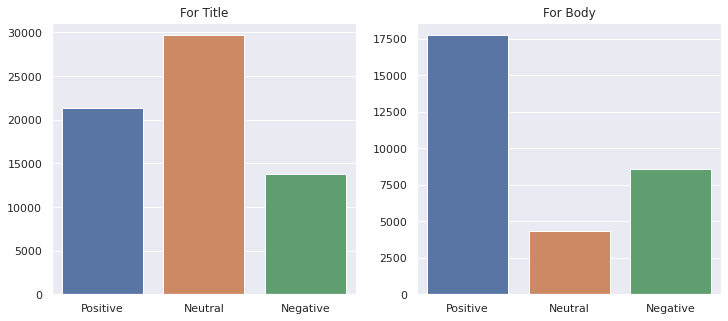

In [ ]:
#Plotting a Bar Graph for Sentiment Counts
fig, (axis1, axis2) = plt.subplots(1,2, figsize=(12,5))

order = ['Positive', 'Neutral', 'Negative']

xs = df_title['Sentiment'].value_counts().index
ys = df_title['Sentiment'].value_counts().values
sns.barplot(x=xs, y=ys, order=order, ax=axis1)

xs = df_selftext['Sentiment'].value_counts().index
ys = df_selftext['Sentiment'].value_counts().values
sns.barplot(x=xs, y=ys, order=order, ax=axis2)

axis1.set_title("For Title")
axis2.set_title("For Body")

plt.show()

#Ben

In [ ]:
!pip install emoji
list(dfs.keys())
df = dfs['MyDrive']

df

emoji_df = df[df.selftext.notna()]

emoji_df = emoji_df[(emoji_df.selftext != '[removed]') | (emoji_df.selftext != '[deleted]')]

import re
import emoji

emoji_df['unique_emojis'] = emoji_df['selftext'].apply(lambda x: [char for char in x if char in emoji.UNICODE_EMOJI['en']]) 


emoji_df.head(60)


,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,title,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink,unique_emojis
0,ko124i,[deleted],2021-01-01 00:02:06,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,1,0,0,"3k - 170k since March (Also, buy LIT!!)",Gain,1.00,34,0,1,14,0,[deleted],default,https://redd.it/ko124i,[]
1,ko12uq,[deleted],2021-01-01 00:03:20,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,0,0,0,Got out of PLTR calls after learning about IV ...,Gain,1.00,2,0,0,0,0,[deleted],default,https://redd.it/ko12uq,[]
2,ko13df,[deleted],2021-01-01 00:04:11,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,0,0,0,Hell of a headline,Meme,0.88,13,0,0,7,0,[deleted],default,https://redd.it/ko13df,[]
4,ko1a4i,WSBVoteBot,2021-01-01 00:15:38,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,0,0,1,0,0,WSBVoteBot Log for Jan 01 2021,None,0.50,0,0,0,19,0,Every time a new submission is posted to walls...,self,https://redd.it/ko1a4i,[]
5,ko1bnp,dluther93,2021-01-01 00:18:03,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,0,1,0,0,What would make GME shorts win?,Discussion,1.00,1,0,0,0,0,[removed],default,https://redd.it/ko1bnp,[]
6,ko1bqz,[deleted],2021-01-01 00:18:13,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,0,0,0,Biden NSA Director pick is prior consultant fo...,DD,1.00,1,0,0,0,0,[deleted],default,https://redd.it/ko1bqz,[]
7,ko1bxc,[deleted],2021-01-01 00:18:32,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,0,1,0,Message from the bulls to the bears for 2021,Meme,0.78,10,0,0,1,0,[deleted],default,https://redd.it/ko1bxc,[]
8,ko1eca,iOinkedU,2021-01-01 00:22:31,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,0,1,0,1,What Really Happened September 3rd 2020,Meme,1.00,1,0,0,0,0,[removed],default,https://redd.it/ko1eca,[]
9,ko1f8e,[deleted],2021-01-01 00:24:02,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,0,0,0,Got my manager to go all in on PLTR and he sen...,None,1.00,1,0,0,1,0,[deleted],default,https://redd.it/ko1f8e,[]
11,ko1jqr,[deleted],2021-01-01 00:31:40,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,0,0,0,Friends don’t let friends be 🌈🐻,News,1.00,1,0,0,0,0,[deleted],default,https://redd.it/ko1jqr,[]


In [ ]:
emojis_used = pd.DataFrame(emoji_df[['created','unique_emojis']])
emojis_used = emojis_used[emojis_used['unique_emojis'].apply(lambda x: len(x)) > 0].explode('unique_emojis').drop_duplicates()
emojis_used['created'] = pd.to_datetime(emojis_used['created'])
emojis_used['date_posted'] = emojis_used['created'].dt.date

In [ ]:
from math import log
to_chart = emojis_used.groupby(['date_posted','unique_emojis']).count().reset_index()
to_chart['date_posted'] = pd.to_datetime(to_chart['date_posted'])
to_chart['logged'] = to_chart['created'].apply(log)
to_chart

,date_posted,unique_emojis,created,logged
0,2021-01-01,♂,1,0.000000
1,2021-01-01,✋,1,0.000000
2,2021-01-01,🌈,2,0.693147
3,2021-01-01,🌕,2,0.693147
4,2021-01-01,🏻,1,0.000000
...,...,...,...,...
4414,2021-08-25,🖐,1,0.000000
4415,2021-08-25,😅,1,0.000000
4416,2021-08-25,🚀,2,0.693147
4417,2021-08-25,🤷,1,0.000000


In [ ]:
alt.Chart(to_chart).mark_line().encode(
    x = 'date_posted:T',
    y = 'created:Q',
    color = 'unique_emojis:N'
).interactive()

alt.Chart(...)

In [ ]:
emojis_used.groupby('unique_emojis')['created'].count().sort_values(ascending = False)

unique_emojis
🚀    4189
💎    2053
🙌     840
🦍     587
🐻     329
     ... 
🐴       1
🤳       1
🐺       1
🐿       1
🫐       1
Name: created, Length: 662, dtype: int64

In [ ]:
moon = to_chart[to_chart['unique_emojis'] == '🚀']
moon

,date_posted,unique_emojis,created,logged
8,2021-01-01,🚀,10,2.302585
16,2021-01-02,🚀,5,1.609438
22,2021-01-03,🚀,7,1.945910
31,2021-01-04,🚀,8,2.079442
39,2021-01-05,🚀,11,2.397895
...,...,...,...,...
4373,2021-08-19,🚀,2,0.693147
4381,2021-08-20,🚀,2,0.693147
4395,2021-08-23,🚀,2,0.693147
4404,2021-08-24,🚀,1,0.000000


In [ ]:
alt.Chart(moon).mark_line().encode(
    x = 'date_posted:T',
    y = 'logged:Q'
).interactive()

alt.Chart(...)

In [ ]:
gme = yf.download("GME", start="2021-01-01", end="2021-09-02")
gme.reset_index(inplace=True)

alt.Chart(gme).mark_line().encode(
    x = 'Date:T',
    y = 'Close:Q'
).interactive()

[*********************100%***********************]  1 of 1 completed


alt.Chart(...)

In [ ]:
moon['rolling'] = moon['created'].rolling(7).sum().apply(log)

display(moon)

alt.Chart(moon).mark_line().encode(
    x = 'date_posted:T',
    y = 'rolling:Q'
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date_posted,unique_emojis,created,logged,rolling
8,2021-01-01,🚀,10,2.302585,NaN
16,2021-01-02,🚀,5,1.609438,NaN
22,2021-01-03,🚀,7,1.945910,NaN
31,2021-01-04,🚀,8,2.079442,NaN
39,2021-01-05,🚀,11,2.397895,NaN
...,...,...,...,...,...
4373,2021-08-19,🚀,2,0.693147,2.708050
4381,2021-08-20,🚀,2,0.693147,2.564949
4395,2021-08-23,🚀,2,0.693147,2.639057
4404,2021-08-24,🚀,1,0.000000,2.639057


alt.Chart(...)

In [ ]:
moon = moon.reset_index(drop = True)
moon['days'] = moon.index -2

gme['Date'] = pd.to_datetime(gme['Date'])
gme['days'] = gme['Date'].apply(lambda x: x - pd.to_datetime('1-3-2021'))
gme['days'] = gme['days']/np.timedelta64(1, 'D')
gme

,Date,Open,High,Low,Close,Adj Close,Volume,days
0,2021-01-04,19.000000,19.100000,17.150000,17.250000,17.250000,10022500,1.0
1,2021-01-05,17.350000,18.080000,17.230000,17.370001,17.370001,4961500,2.0
2,2021-01-06,17.340000,18.980000,17.330000,18.360001,18.360001,6056200,3.0
3,2021-01-07,18.469999,19.450001,18.020000,18.080000,18.080000,6129300,4.0
4,2021-01-08,18.180000,18.299999,17.080000,17.690001,17.690001,6482000,5.0
...,...,...,...,...,...,...,...,...
163,2021-08-26,200.679993,217.000000,199.000000,205.220001,205.220001,6238600,235.0
164,2021-08-27,207.699997,213.000000,200.020004,204.949997,204.949997,3224900,236.0
165,2021-08-30,205.000000,218.190002,203.020004,209.199997,209.199997,3309600,239.0
166,2021-08-31,212.699997,222.300003,211.460007,218.240005,218.240005,3574700,240.0


In [ ]:
moon[['days','logged']]
gme[['Close','days']]

(     days    logged
 0      -2  2.302585
 1      -1  1.609438
 2       0  1.945910
 3       1  2.079442
 4       2  2.397895
 ..    ...       ...
 211   209  1.098612
 212   210  0.000000
 213   211  1.098612
 214   212  1.791759
 215   213  0.693147
 
 [216 rows x 2 columns],           Close   days
 0     17.250000    1.0
 1     17.370001    2.0
 2     18.360001    3.0
 3     18.080000    4.0
 4     17.690001    5.0
 ..          ...    ...
 163  205.220001  235.0
 164  204.949997  236.0
 165  209.199997  239.0
 166  218.240005  240.0
 167  212.970001  241.0
 
 [168 rows x 2 columns])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(gme[['Close','days']]))
scaler.fit_transform(moon[['logged','days']])

price = alt.Chart(pd.DataFrame(scaler.fit_transform(gme[['Close','days']]))).mark_line(color = 'green').encode(
    x = '1:Q',
    y = '0:Q'
)

rocket = alt.Chart(pd.DataFrame(scaler.fit_transform(moon[['logged','days']]))).mark_line(color = 'red').encode(
    x = '1:Q',
    y = '0:Q'

)

price + rocket

StandardScaler(copy=True, with_mean=True, with_std=True)


alt.LayerChart(...)

**Vlad's Workspace**

In [ ]:
df = dfs['MyDrive']
mentions_df = df[df.title.notna()]

mentions_df.loc[:, 'mention_gme'] = 0
mentions_df.loc[:, 'mention_amc'] = 0
mentions_df.loc[:, 'mention_spy'] = 0
mentions_df.loc[:, 'mention_bb'] = 0

mentions_df['created_date'] = pd.to_datetime(mentions_df['created']).dt.date

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [ ]:
pattern_1 = re.compile(r'(GME)|(gamestop)', re.IGNORECASE)
mentions_df['mention_gme'] = mentions_df.apply(lambda row: 1 if pattern_1.search(row.title) else row.mention_gme , axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
pattern_2 = re.compile(r'(AMC)|(amc theaters)', re.IGNORECASE)
mentions_df['mention_amc'] = mentions_df.apply(lambda row: 1 if pattern_2.search(row.title) else row.mention_amc , axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
pattern_3 = re.compile(r'(SPY)', re.IGNORECASE)
mentions_df['mention_spy'] = mentions_df.apply(lambda row: 1 if pattern_3.search(row.title) else row.mention_spy , axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
pattern_4 = re.compile(r'(BB)|Blackberry', re.IGNORECASE)
mentions_df['mention_bb'] = mentions_df.apply(lambda row: 1 if pattern_4.search(row.title) else row.mention_bb , axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
mentions_sum = mentions_df.groupby(['created_date']).sum().reset_index()

In [ ]:
mentions_sum['created_date'] = mentions_sum['created_date'].astype(str)

In [ ]:
#GME Mentions
alt.Chart(mentions_sum).mark_line().encode(
    x = 'created_date:T',
    y = alt.Y('mention_gme:Q',
              scale=alt.Scale(type='log'))
)

alt.Chart(...)

In [ ]:
#AMC Mentions
alt.Chart(mentions_sum).transform_filter(
    alt.datum.mention_amc > 0  
).mark_line().encode(
    x = 'created_date:T',
    y = alt.Y('mention_amc:Q',
              scale=alt.Scale(type='log'))
)

alt.Chart(...)

In [ ]:
#SPY Mentions
alt.Chart(mentions_sum).transform_filter(
    alt.datum.mention_spy > 0  
).mark_line().encode(
    x = 'created_date:T',
    y = alt.Y('mention_spy:Q',
              scale=alt.Scale(type='log'))
)

alt.Chart(...)

In [ ]:
#BB Mentions
alt.Chart(mentions_sum).transform_filter(
    alt.datum.mention_bb > 0  
).mark_line().encode(
    x = 'created_date:T',
    y = alt.Y('mention_bb:Q',
              scale=alt.Scale(type='log'))
)

alt.Chart(...)

In [ ]:
mentions_sum['created_date'] = pd.to_datetime(mentions_sum['created_date'])

In [ ]:
yf_gme = yf.download("GME", start="2021-01-01", end="2021-09-02")
yf_gme.reset_index(inplace=True)
yf_gme_merged = pd.merge(yf_gme, mentions_sum, left_on='Date', right_on='created_date')

[*********************100%***********************]  1 of 1 completed


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

X_gme = np.asarray(yf_gme_merged[['Close']])
y_gme = np.asarray(yf_gme_merged[['mention_gme']])

reg_gme = LinearRegression().fit(X_gme, y_gme)
display(reg_gme.score(X_gme, y_gme))

0.020112026519490067

In [ ]:
import statsmodels.api as sm

model = sm.OLS(y_gme, X_gme)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.075
Model:                            OLS   Adj. R-squared (uncentered):              0.069
Method:                 Least Squares   F-statistic:                              12.56
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                    0.000521
Time:                        20:53:04   Log-Likelihood:                         -1414.5
No. Observations:                 156   AIC:                                      2831.
Df Residuals:                     155   BIC:                                      2834.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
yf_amc = yf.download("AMC", start="2021-01-01", end="2021-09-02")
yf_amc.reset_index(inplace=True)
yf_amc_merged = pd.merge(yf_amc, mentions_sum, left_on='Date', right_on='created_date')

[*********************100%***********************]  1 of 1 completed


In [ ]:
X_amc = np.asarray(yf_amc_merged[['Close']])
y_amc = np.asarray(yf_amc_merged[['mention_amc']])

reg_amc = LinearRegression().fit(X_amc, y_amc)
display(reg_amc.score(X_amc, y_amc))

0.0027569796740671837

In [ ]:
model = sm.OLS(y_amc, X_amc)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.022
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              3.417
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                      0.0664
Time:                        20:55:40   Log-Likelihood:                         -1306.6
No. Observations:                 156   AIC:                                      2615.
Df Residuals:                     155   BIC:                                      2618.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
model = sm.OLS(y_gme, X_amc)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              1.396
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                       0.239
Time:                        20:58:32   Log-Likelihood:                         -1419.9
No. Observations:                 156   AIC:                                      2842.
Df Residuals:                     155   BIC:                                      2845.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
yf_spy = yf.download("SPY", start="2021-01-01", end="2021-09-02")
yf_spy.reset_index(inplace=True)
yf_spy_merged = pd.merge(yf_spy, mentions_sum, left_on='Date', right_on='created_date')

[*********************100%***********************]  1 of 1 completed


In [ ]:
X_spy = np.asarray(yf_spy_merged[['Close']])
y_spy = np.asarray(yf_spy_merged[['mention_bb']])

reg_bb = LinearRegression().fit(X_spy, y_spy)
display(reg_bb.score(X_spy, y_spy))

0.06041851670260934

In [ ]:
model = sm.OLS(y_spy, X_spy)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.056
Model:                            OLS   Adj. R-squared (uncentered):              0.050
Method:                 Least Squares   F-statistic:                              9.189
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                     0.00285
Time:                        20:59:46   Log-Likelihood:                         -1202.9
No. Observations:                 156   AIC:                                      2408.
Df Residuals:                     155   BIC:                                      2411.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
yf_bb = yf.download("BB", start="2021-01-01", end="2021-09-02")
yf_bb.reset_index(inplace=True)
yf_bb_merged = pd.merge(yf_bb, mentions_sum, left_on='Date', right_on='created_date')

[*********************100%***********************]  1 of 1 completed


In [ ]:
X_bb = np.asarray(yf_bb_merged[['Close']])
y_bb = np.asarray(yf_bb_merged[['mention_bb']])

reg_bb = LinearRegression().fit(X_bb, y_bb)
display(reg_bb.score(X_bb, y_bb))

0.24070539525034285

In [ ]:
model = sm.OLS(y_bb, X_bb)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.122
Model:                            OLS   Adj. R-squared (uncentered):              0.116
Method:                 Least Squares   F-statistic:                              21.56
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                    7.25e-06
Time:                        20:57:09   Log-Likelihood:                         -1197.3
No. Observations:                 156   AIC:                                      2397.
Df Residuals:                     155   BIC:                                      2400.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------